## MSDS458 Research Assignment 02 Experiments

Experiment 1: DNN with 2 layers (no regularization)

Experiment 2: DNN with 3 layers (no regularization)

Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)

Experiment 4: CNN with 3 convolution/max pooling layers (no regularization)

Experiment 5+ : You will conduct several more experiments. 
(a) Redo all the 4 experiments with some regularization technique. 
(b) Create more experiments on your own by tweaking architectures and/or hyper parameters.

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Import packages needed 

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.7.0


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.7.0


### Mount Google Drive to Colab Environment

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Functions for Research Assignment

In [6]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [7]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [9]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


### Review labels for training dataset

In [10]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


### Plot Examples

In [11]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [12]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [13]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

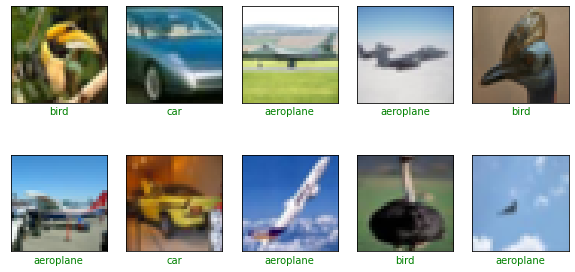

In [14]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

### Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [15]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

### Create Validation Data Set

In [16]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

### Confirm Datasets {Train, Validation, Test}

In [17]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


### Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [18]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


In [19]:
"""
#Build CNN Model
#We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning. The last 3 layers, handle classification
model = models.Sequential()
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))
"""

'\n#Build CNN Model\n#We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning. The last 3 layers, handle classification\nmodel = models.Sequential()\nmodel.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))\nmodel.add(layers.MaxPool2D((2, 2),strides=2))\nmodel.add(layers.Dropout(0.3))\nmodel.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))\nmodel.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))\nmodel.add(layers.Dropout(0.3))\nmodel.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))\nmodel.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))\nmodel.add(layers.Dropout(0.3))\nmodel.add(layers.Flatten())\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))\nmodel.add(layers.D

In [20]:
def namestr(obj, namespace):
  for name in namespace:
    if namespace[name] is obj:
      return name

In [21]:
import datetime as dt

def compile_train_model_with_reg(model, epoch, batch):
  #compile model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

  start_datetime = dt.datetime.now()

  #train model
  history = model.fit(x_train_norm
                      ,y_train_split
                      ,epochs=epoch
                      ,batch_size=batch
                      ,validation_data=(x_valid_norm, y_valid_split)
                      ,callbacks=[
                      tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) # remove early stop so that we can see if the model is able to overfit
                      #tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                      #                    save_weights_only=False, monitor='val_accuracy')
                      ]                                                                                                           
                    )

  #evaluate model
  loss, accuracy = model.evaluate(x_test_norm, y_test)
  print('test set accuracy: ', accuracy * 100)

  #predict model
  preds = model.predict(x_test_norm)

  runtime = (dt.datetime.now() - start_datetime).total_seconds()

  #training and validation performance metrix
  history_dict = history.history
  history_df=pd.DataFrame(history_dict)

  result = history_df.tail(1)
  result['test_loss'] = loss
  result['test_accuracy'] = accuracy
  result['process_time'] = runtime
  result['epochs'] = epoch  
  result['batch_size'] = batch    

  #loss and accuracy for training and validation data
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
      plt.subplot(1, 2, i + 1)
      plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
      plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
      plt.legend()
      plt.title('{0} with {1} epochs and {2} batch size'.format(namestr(model, globals()), epoch, batch))   
  plt.show()  

  return result

In [22]:
import datetime as dt

def compile_train_plot_model(model, epoch, batch):
  #plot model
  keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

  #compile model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

  start_datetime = dt.datetime.now()

  #train model
  history = model.fit(x_train_norm
                      ,y_train_split
                      ,epochs=epoch
                      ,batch_size=batch
                      ,validation_data=(x_valid_norm, y_valid_split)
                      #,callbacks=[
                      #tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                      #tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                      #                    save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                    )

  #evaluate model
  loss, accuracy = model.evaluate(x_test_norm, y_test)
  print('test set accuracy: ', accuracy * 100)

  #predict model
  preds = model.predict(x_test_norm)

  runtime = (dt.datetime.now() - start_datetime).total_seconds()

  #training and validation performance metrix
  history_dict = history.history
  history_df=pd.DataFrame(history_dict)

  result = history_df.tail(1)
  result['test_loss'] = loss
  result['test_accuracy'] = accuracy
  result['process_time'] = runtime
  result['epochs'] = epoch  
  result['batch_size'] = batch    

  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  #loss and accuracy for training and validation data
  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
      plt.subplot(1, 2, i + 1)
      plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
      plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
      plt.legend()
      plt.title('{0} with {1} epochs and {2} batch size'.format(namestr(model, globals()), epoch, batch))          
  plt.show()                        

  #confuison matrix
  pred1= model.predict(x_test_norm)
  pred1=np.argmax(pred1, axis=1)
  print_validation_report(y_test, pred1)
  plot_confusion_matrix(y_test,pred1)

  return result


### Experiment 1: DNN with 2 layers (no regularization)

In [23]:
model1 = models.Sequential()
model1.add(layers.InputLayer(input_shape=(32, 32, 3)))
model1.add(layers.Flatten(name ='flatten'))
model1.add(layers.Dense(name = "hidden_layer",units=384, activation=tf.nn.relu))
model1.add(layers.Dense(name = "hidden_layer2",units=384, activation=tf.nn.relu))
model1.add(layers.Dense(name = "output_layer",units=10, activation=tf.nn.softmax))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 hidden_layer (Dense)        (None, 384)               1180032   
                                                                 
 hidden_layer2 (Dense)       (None, 384)               147840    
                                                                 
 output_layer (Dense)        (None, 10)                3850      
                                                                 
Total params: 1,331,722
Trainable params: 1,331,722
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
450/450 [==============================] - 6s 6ms/step - loss: 1.8787 - accuracy: 0.3254 - val_loss: 1.7821 - val_accuracy: 0.3478
Epoch 2/20
450/450 [==============================] - 2s 5ms/step - loss: 1.6675 - accuracy: 0.4039 - val_loss: 1.6488 - val_accuracy: 0.4112
Epoch 3/20
450/450 [==============================] - 2s 5ms/step - loss: 1.5816 - accuracy: 0.4361 - val_loss: 1.5538 - val_accuracy: 0.4442
Epoch 4/20
450/450 [==============================] - 2s 5ms/step - loss: 1.5254 - accuracy: 0.4557 - val_loss: 1.6005 - val_accuracy: 0.4310
Epoch 5/20
450/450 [==============================] - 2s 5ms/step - loss: 1.4810 - accuracy: 0.4720 - val_loss: 1.5125 - val_accuracy: 0.4570
Epoch 6/20
450/450 [==============================] - 2s 5ms/step - loss: 1.4460 - accuracy: 0.4853 - val_loss: 1.4803 - val_accuracy: 0.4604
Epoch 7/20
450/450 [==============================] - 2s 5ms/step - loss: 1.4126 - accuracy: 0.4951 - val_loss: 1.5287 - val_accuracy: 0.4560
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

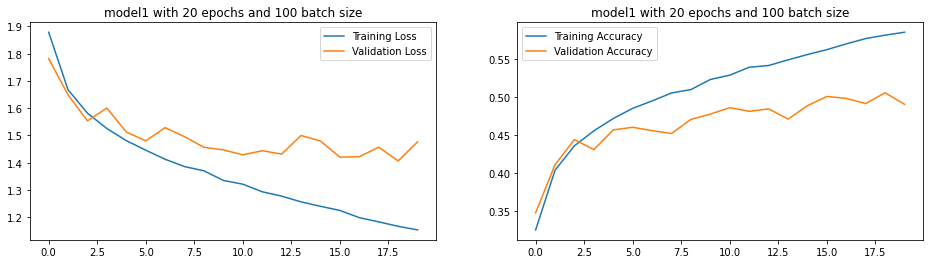

Classification Report
              precision    recall  f1-score   support

           0       0.60      0.49      0.54      1000
           1       0.65      0.59      0.62      1000
           2       0.37      0.43      0.40      1000
           3       0.35      0.29      0.32      1000
           4       0.47      0.41      0.44      1000
           5       0.44      0.40      0.42      1000
           6       0.48      0.61      0.54      1000
           7       0.74      0.40      0.52      1000
           8       0.45      0.82      0.58      1000
           9       0.56      0.47      0.51      1000

    accuracy                           0.49     10000
   macro avg       0.51      0.49      0.49     10000
weighted avg       0.51      0.49      0.49     10000

Accuracy Score: 0.4931
Root Mean Square Error: 3.1178037141552064


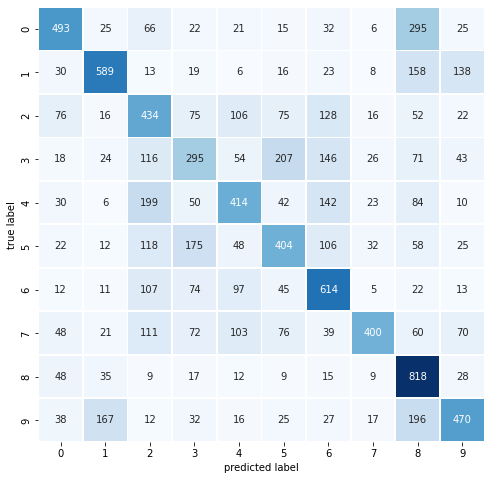

In [24]:
result1 = compile_train_plot_model(model1, 20, 100)

In [25]:
assignment_result_table = result1
new_col = ['DNN with 2 layers (no regularization)']   
assignment_result_table.insert(loc=0, column='Model', value=new_col)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
19,DNN with 2 layers (no regularization),1.153518,0.585422,1.476373,0.4906,1.462329,0.4931,56.941556,20,100


Epoch 1/100
88/88 [==============================] - 2s 12ms/step - loss: 1.0539 - accuracy: 0.6246 - val_loss: 1.3816 - val_accuracy: 0.5292
Epoch 2/100
88/88 [==============================] - 1s 10ms/step - loss: 1.0191 - accuracy: 0.6373 - val_loss: 1.3947 - val_accuracy: 0.5166
Epoch 3/100
88/88 [==============================] - 1s 10ms/step - loss: 1.0107 - accuracy: 0.6386 - val_loss: 1.4027 - val_accuracy: 0.5198
Epoch 4/100
88/88 [==============================] - 1s 9ms/step - loss: 1.0056 - accuracy: 0.6393 - val_loss: 1.4212 - val_accuracy: 0.5208
Epoch 5/100
88/88 [==============================] - 1s 10ms/step - loss: 0.9907 - accuracy: 0.6476 - val_loss: 1.4163 - val_accuracy: 0.5204
Epoch 6/100
88/88 [==============================] - 1s 10ms/step - loss: 0.9768 - accuracy: 0.6516 - val_loss: 1.4176 - val_accuracy: 0.5250
Epoch 7/100
88/88 [==============================] - 1s 10ms/step - loss: 0.9716 - accuracy: 0.6544 - val_loss: 1.4203 - val_accuracy: 0.5196
Epoch 8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

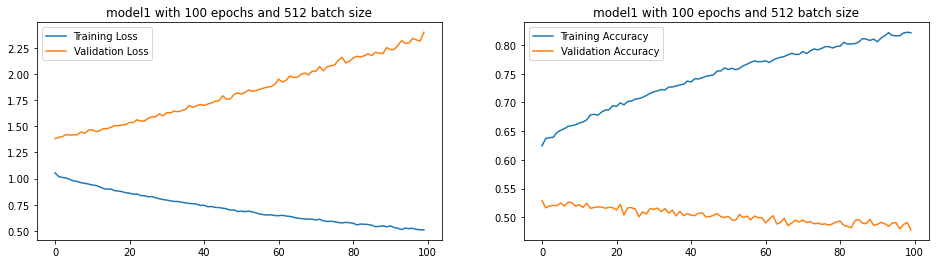

Classification Report
              precision    recall  f1-score   support

           0       0.51      0.60      0.55      1000
           1       0.63      0.52      0.57      1000
           2       0.36      0.35      0.36      1000
           3       0.36      0.33      0.34      1000
           4       0.43      0.47      0.45      1000
           5       0.43      0.35      0.38      1000
           6       0.49      0.59      0.54      1000
           7       0.53      0.54      0.53      1000
           8       0.60      0.62      0.61      1000
           9       0.56      0.52      0.54      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000

Accuracy Score: 0.4891
Root Mean Square Error: 3.137467131301936


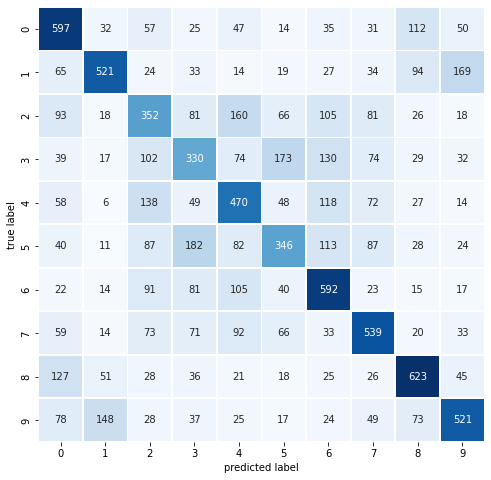

In [26]:
result1_1 = compile_train_plot_model(model1, 100, 512)

In [27]:
new_col = ['DNN with 2 layers (no regularization)']   
result1_1.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result1_1, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.153518,0.585422,1.476373,0.4906,1.462329,0.4931,56.941556,20,100
1,DNN with 2 layers (no regularization),0.508875,0.821222,2.399958,0.4782,2.324218,0.4891,98.645602,100,512


## Experiment 2: DNN with 3 layers (no regularization)

In [28]:
model2 = models.Sequential()
model2.add(layers.InputLayer(input_shape=(32, 32, 3)))
model2.add(layers.Flatten(name ='flatten'))
model2.add(layers.Dense(name = "hidden_layer",units=384, activation=tf.nn.relu))
model2.add(layers.Dense(name = "hidden_layer2",units=384, activation=tf.nn.relu))
model2.add(layers.Dense(name = "hidden_layer3",units=384, activation=tf.nn.relu))
model2.add(layers.Dense(name = "output_layer",units=10, activation=tf.nn.softmax))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 hidden_layer (Dense)        (None, 384)               1180032   
                                                                 
 hidden_layer2 (Dense)       (None, 384)               147840    
                                                                 
 hidden_layer3 (Dense)       (None, 384)               147840    
                                                                 
 output_layer (Dense)        (None, 10)                3850      
                                                                 
Total params: 1,479,562
Trainable params: 1,479,562
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
450/450 [==============================] - 4s 7ms/step - loss: 1.8663 - accuracy: 0.3201 - val_loss: 1.7704 - val_accuracy: 0.3556
Epoch 2/20
450/450 [==============================] - 4s 9ms/step - loss: 1.6786 - accuracy: 0.3946 - val_loss: 1.6424 - val_accuracy: 0.4000
Epoch 3/20
450/450 [==============================] - 3s 7ms/step - loss: 1.5849 - accuracy: 0.4334 - val_loss: 1.5837 - val_accuracy: 0.4338
Epoch 4/20
450/450 [==============================] - 3s 6ms/step - loss: 1.5276 - accuracy: 0.4526 - val_loss: 1.5926 - val_accuracy: 0.4242
Epoch 5/20
450/450 [==============================] - 3s 6ms/step - loss: 1.4723 - accuracy: 0.4732 - val_loss: 1.5143 - val_accuracy: 0.4558
Epoch 6/20
450/450 [==============================] - 3s 6ms/step - loss: 1.4384 - accuracy: 0.4859 - val_loss: 1.5526 - val_accuracy: 0.4428
Epoch 7/20
450/450 [==============================] - 3s 6ms/step - loss: 1.4071 - accuracy: 0.4957 - val_loss: 1.5009 - val_accuracy: 0.4680
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

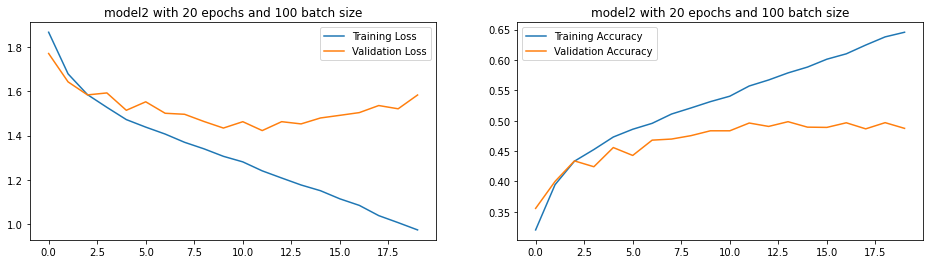

Classification Report
              precision    recall  f1-score   support

           0       0.59      0.54      0.56      1000
           1       0.57      0.65      0.61      1000
           2       0.40      0.33      0.36      1000
           3       0.32      0.33      0.32      1000
           4       0.38      0.50      0.43      1000
           5       0.43      0.35      0.39      1000
           6       0.61      0.44      0.51      1000
           7       0.49      0.60      0.54      1000
           8       0.62      0.63      0.62      1000
           9       0.55      0.54      0.54      1000

    accuracy                           0.49     10000
   macro avg       0.50      0.49      0.49     10000
weighted avg       0.50      0.49      0.49     10000

Accuracy Score: 0.4925
Root Mean Square Error: 3.0593136485166084


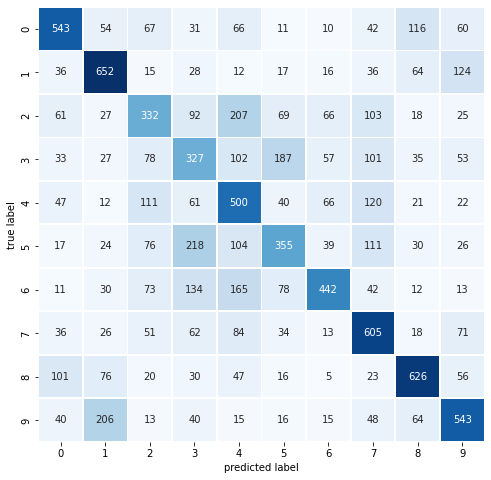

In [29]:
result2 = compile_train_plot_model(model2,20,100) 

In [30]:
new_col = ['DNN with 3 layers (no regularization)']   
result2.insert(loc=0, column='Model', value=new_col)

assignment_result_table = assignment_result_table.append(result2, ignore_index = True)

assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.153518,0.585422,1.476373,0.4906,1.462329,0.4931,56.941556,20,100
1,DNN with 2 layers (no regularization),0.508875,0.821222,2.399958,0.4782,2.324218,0.4891,98.645602,100,512
2,DNN with 3 layers (no regularization),0.974704,0.645733,1.583275,0.4874,1.550352,0.4925,57.029117,20,100


Epoch 1/100
88/88 [==============================] - 2s 13ms/step - loss: 0.8105 - accuracy: 0.7119 - val_loss: 1.5848 - val_accuracy: 0.5032
Epoch 2/100
88/88 [==============================] - 1s 11ms/step - loss: 0.7467 - accuracy: 0.7359 - val_loss: 1.5988 - val_accuracy: 0.4970
Epoch 3/100
88/88 [==============================] - 1s 10ms/step - loss: 0.7149 - accuracy: 0.7471 - val_loss: 1.6521 - val_accuracy: 0.5022
Epoch 4/100
88/88 [==============================] - 1s 11ms/step - loss: 0.6787 - accuracy: 0.7628 - val_loss: 1.6898 - val_accuracy: 0.4970
Epoch 5/100
88/88 [==============================] - 1s 11ms/step - loss: 0.6565 - accuracy: 0.7690 - val_loss: 1.7235 - val_accuracy: 0.4980
Epoch 6/100
88/88 [==============================] - 1s 10ms/step - loss: 0.6203 - accuracy: 0.7838 - val_loss: 1.7393 - val_accuracy: 0.4966
Epoch 7/100
88/88 [==============================] - 1s 10ms/step - loss: 0.5892 - accuracy: 0.7972 - val_loss: 1.8279 - val_accuracy: 0.4956
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

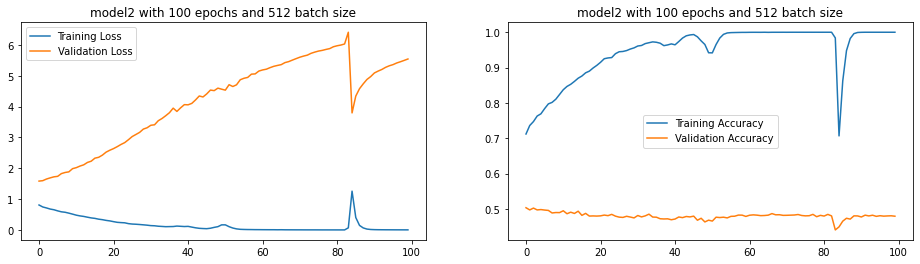

Classification Report
              precision    recall  f1-score   support

           0       0.56      0.57      0.56      1000
           1       0.60      0.58      0.59      1000
           2       0.37      0.36      0.37      1000
           3       0.31      0.32      0.31      1000
           4       0.41      0.41      0.41      1000
           5       0.39      0.40      0.39      1000
           6       0.52      0.55      0.53      1000
           7       0.56      0.54      0.55      1000
           8       0.60      0.60      0.60      1000
           9       0.54      0.53      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.49      0.48      0.49     10000
weighted avg       0.49      0.48      0.49     10000

Accuracy Score: 0.4848
Root Mean Square Error: 3.0798538926384156


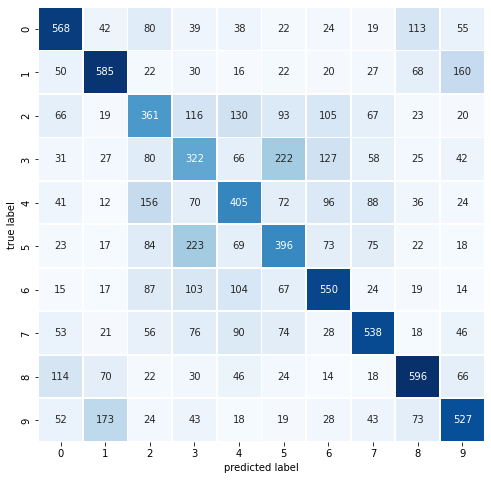

In [31]:
result2_2 = compile_train_plot_model(model2,100,512) 

In [32]:
new_col = ['DNN with 3 layers (no regularization)']   
result2_2.insert(loc=0, column='Model', value=new_col)

assignment_result_table = assignment_result_table.append(result2_2, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.153518,0.585422,1.476373,0.4906,1.462329,0.4931,56.941556,20,100
1,DNN with 2 layers (no regularization),0.508875,0.821222,2.399958,0.4782,2.324218,0.4891,98.645602,100,512
2,DNN with 3 layers (no regularization),0.974704,0.645733,1.583275,0.4874,1.550352,0.4925,57.029117,20,100
3,DNN with 3 layers (no regularization),0.004116,1.000000,5.543856,0.4792,5.315418,0.4848,99.278612,100,512


## Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)

In [33]:
model3 = models.Sequential()
model3.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model3.add(layers.MaxPool2D((2, 2),strides=2))
model3.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model3.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model3.add(layers.Flatten())
model3.add(layers.Dense(units=384, activation=tf.nn.relu))
model3.add(layers.Dense(units=10, activation=tf.nn.softmax))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 384)              

Epoch 1/20
450/450 [==============================] - 26s 37ms/step - loss: 1.4661 - accuracy: 0.4734 - val_loss: 1.1926 - val_accuracy: 0.5844
Epoch 2/20
450/450 [==============================] - 12s 27ms/step - loss: 1.0798 - accuracy: 0.6212 - val_loss: 1.0181 - val_accuracy: 0.6352
Epoch 3/20
450/450 [==============================] - 14s 30ms/step - loss: 0.9197 - accuracy: 0.6796 - val_loss: 0.9356 - val_accuracy: 0.6600
Epoch 4/20
450/450 [==============================] - 12s 27ms/step - loss: 0.7940 - accuracy: 0.7244 - val_loss: 0.9133 - val_accuracy: 0.6730
Epoch 5/20
450/450 [==============================] - 12s 27ms/step - loss: 0.6903 - accuracy: 0.7597 - val_loss: 0.8425 - val_accuracy: 0.7182
Epoch 6/20
450/450 [==============================] - 12s 26ms/step - loss: 0.5861 - accuracy: 0.7953 - val_loss: 0.8492 - val_accuracy: 0.7200
Epoch 7/20
450/450 [==============================] - 12s 27ms/step - loss: 0.4823 - accuracy: 0.8318 - val_loss: 0.8620 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

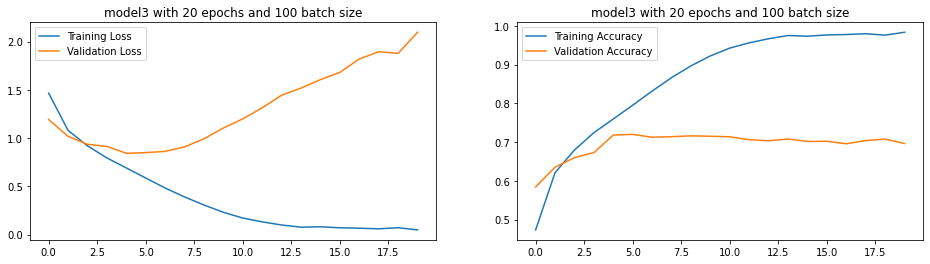

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      1000
           1       0.76      0.86      0.81      1000
           2       0.66      0.54      0.59      1000
           3       0.46      0.56      0.51      1000
           4       0.65      0.65      0.65      1000
           5       0.58      0.63      0.60      1000
           6       0.75      0.80      0.77      1000
           7       0.81      0.74      0.77      1000
           8       0.83      0.79      0.81      1000
           9       0.86      0.68      0.76      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000

Accuracy Score: 0.7016
Root Mean Square Error: 2.244883070451555


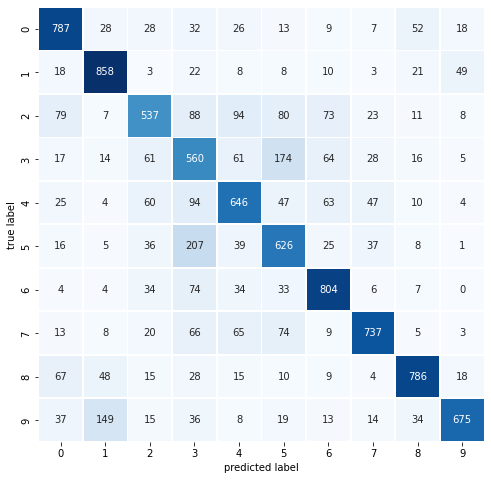

In [34]:
result3 = compile_train_plot_model(model3, 20, 100)

In [35]:
new_col = ['CNN with 2 convolution/max pooling layers (no regularization)']   
result3.insert(loc=0, column='Model', value=new_col)

assignment_result_table = assignment_result_table.append(result3, ignore_index = True)

assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.153518,0.585422,1.476373,0.4906,1.462329,0.4931,56.941556,20,100
1,DNN with 2 layers (no regularization),0.508875,0.821222,2.399958,0.4782,2.324218,0.4891,98.645602,100,512
2,DNN with 3 layers (no regularization),0.974704,0.645733,1.583275,0.4874,1.550352,0.4925,57.029117,20,100
3,DNN with 3 layers (no regularization),0.004116,1.000000,5.543856,0.4792,5.315418,0.4848,99.278612,100,512
4,CNN with 2 convolution/max pooling layers (no ...,0.047906,0.983622,2.097271,0.6964,2.077970,0.7016,262.758396,20,100


Epoch 1/100
88/88 [==============================] - 12s 121ms/step - loss: 0.0157 - accuracy: 0.9956 - val_loss: 2.0983 - val_accuracy: 0.7176
Epoch 2/100
88/88 [==============================] - 8s 96ms/step - loss: 0.0037 - accuracy: 0.9995 - val_loss: 2.1432 - val_accuracy: 0.7228
Epoch 3/100
88/88 [==============================] - 8s 96ms/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 2.2116 - val_accuracy: 0.7260
Epoch 4/100
88/88 [==============================] - 9s 97ms/step - loss: 4.8006e-04 - accuracy: 1.0000 - val_loss: 2.2630 - val_accuracy: 0.7280
Epoch 5/100
88/88 [==============================] - 8s 96ms/step - loss: 2.9232e-04 - accuracy: 1.0000 - val_loss: 2.3167 - val_accuracy: 0.7288
Epoch 6/100
88/88 [==============================] - 8s 96ms/step - loss: 2.2622e-04 - accuracy: 1.0000 - val_loss: 2.3505 - val_accuracy: 0.7286
Epoch 7/100
88/88 [==============================] - 8s 96ms/step - loss: 1.8759e-04 - accuracy: 1.0000 - val_loss: 2.3848 - val_accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

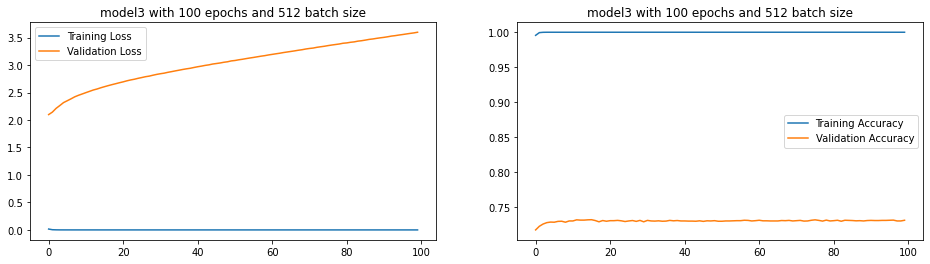

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1000
           1       0.82      0.83      0.83      1000
           2       0.67      0.63      0.65      1000
           3       0.54      0.53      0.54      1000
           4       0.68      0.69      0.68      1000
           5       0.62      0.63      0.63      1000
           6       0.80      0.81      0.81      1000
           7       0.79      0.76      0.78      1000
           8       0.83      0.84      0.83      1000
           9       0.81      0.80      0.80      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000

Accuracy Score: 0.7327
Root Mean Square Error: 2.110995026048143


,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.153518e+00,0.585422,1.476373,0.4906,1.462329,0.4931,56.941556,20,100
1,DNN with 2 layers (no regularization),5.088747e-01,0.821222,2.399958,0.4782,2.324218,0.4891,98.645602,100,512
2,DNN with 3 layers (no regularization),9.747038e-01,0.645733,1.583275,0.4874,1.550352,0.4925,57.029117,20,100
3,DNN with 3 layers (no regularization),4.115602e-03,1.000000,5.543856,0.4792,5.315418,0.4848,99.278612,100,512
4,CNN with 2 convolution/max pooling layers (no ...,4.790628e-02,0.983622,2.097271,0.6964,2.077970,0.7016,262.758396,20,100
5,CNN with 2 convolution/max pooling layers (no ...,5.665425e-07,1.000000,3.596411,0.7314,3.639973,0.7327,867.420595,100,512


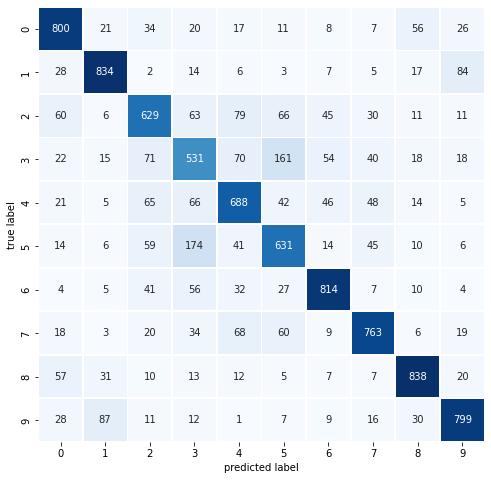

In [36]:
result3_2 = compile_train_plot_model(model3,100,512) 

new_col = ['CNN with 2 convolution/max pooling layers (no regularization)']   
result3_2.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result3_2, ignore_index = True)
assignment_result_table

## Experiment 4: CNN with 3 convolution/max pooling layers (no regularization)

In [37]:
model4 = models.Sequential()
model4.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model4.add(layers.MaxPool2D((2, 2),strides=2))
model4.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model4.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model4.add(layers.Flatten())
model4.add(layers.Dense(units=384, activation=tf.nn.relu))
model4.add(layers.Dense(units=10, activation=tf.nn.softmax))

model4.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 512)         1180160   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 512)       

Epoch 1/20
450/450 [==============================] - 16s 34ms/step - loss: 1.5235 - accuracy: 0.4442 - val_loss: 1.3384 - val_accuracy: 0.5140
Epoch 2/20
450/450 [==============================] - 15s 33ms/step - loss: 1.0836 - accuracy: 0.6194 - val_loss: 1.0330 - val_accuracy: 0.6264
Epoch 3/20
450/450 [==============================] - 15s 33ms/step - loss: 0.8714 - accuracy: 0.6940 - val_loss: 0.8537 - val_accuracy: 0.6986
Epoch 4/20
450/450 [==============================] - 15s 33ms/step - loss: 0.7212 - accuracy: 0.7496 - val_loss: 0.8012 - val_accuracy: 0.7232
Epoch 5/20
450/450 [==============================] - 15s 33ms/step - loss: 0.6058 - accuracy: 0.7879 - val_loss: 0.7636 - val_accuracy: 0.7374
Epoch 6/20
450/450 [==============================] - 15s 33ms/step - loss: 0.4865 - accuracy: 0.8302 - val_loss: 0.7598 - val_accuracy: 0.7456
Epoch 7/20
450/450 [==============================] - 15s 33ms/step - loss: 0.3841 - accuracy: 0.8653 - val_loss: 0.8161 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

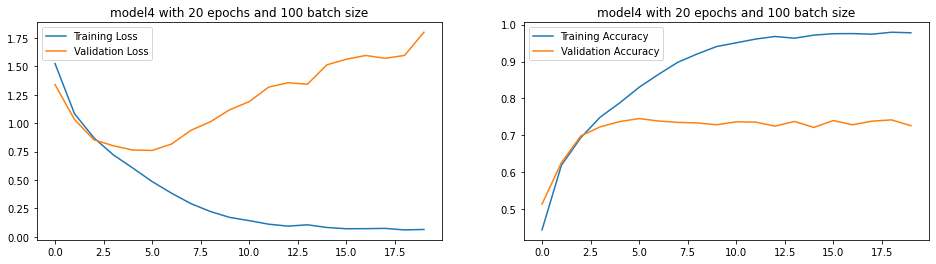

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1000
           1       0.83      0.86      0.84      1000
           2       0.73      0.56      0.63      1000
           3       0.60      0.52      0.55      1000
           4       0.64      0.75      0.69      1000
           5       0.62      0.67      0.65      1000
           6       0.68      0.90      0.77      1000
           7       0.84      0.72      0.78      1000
           8       0.88      0.77      0.82      1000
           9       0.82      0.81      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000

Accuracy Score: 0.7344
Root Mean Square Error: 2.120471645648675


,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.153518e+00,0.585422,1.476373,0.4906,1.462329,0.4931,56.941556,20,100
1,DNN with 2 layers (no regularization),5.088747e-01,0.821222,2.399958,0.4782,2.324218,0.4891,98.645602,100,512
2,DNN with 3 layers (no regularization),9.747038e-01,0.645733,1.583275,0.4874,1.550352,0.4925,57.029117,20,100
3,DNN with 3 layers (no regularization),4.115602e-03,1.000000,5.543856,0.4792,5.315418,0.4848,99.278612,100,512
4,CNN with 2 convolution/max pooling layers (no ...,4.790628e-02,0.983622,2.097271,0.6964,2.077970,0.7016,262.758396,20,100
5,CNN with 2 convolution/max pooling layers (no ...,5.665425e-07,1.000000,3.596411,0.7314,3.639973,0.7327,867.420595,100,512
6,CNN with 3 convolution/max pooling layers (no ...,6.505650e-02,0.977822,1.798882,0.7262,1.777424,0.7344,329.427057,20,100


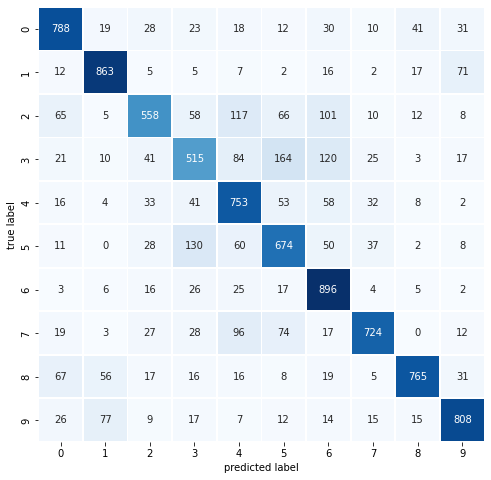

In [38]:
result4 = compile_train_plot_model(model4, 20, 100)

new_col = ['CNN with 3 convolution/max pooling layers (no regularization)']   
result4.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result4, ignore_index = True)
assignment_result_table

Epoch 1/100
88/88 [==============================] - 14s 140ms/step - loss: 0.0183 - accuracy: 0.9940 - val_loss: 1.8182 - val_accuracy: 0.7530
Epoch 2/100
88/88 [==============================] - 11s 121ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 2.0021 - val_accuracy: 0.7436
Epoch 3/100
88/88 [==============================] - 11s 120ms/step - loss: 0.0110 - accuracy: 0.9967 - val_loss: 2.0597 - val_accuracy: 0.7456
Epoch 4/100
88/88 [==============================] - 11s 120ms/step - loss: 0.0125 - accuracy: 0.9961 - val_loss: 2.0562 - val_accuracy: 0.7466
Epoch 5/100
88/88 [==============================] - 11s 120ms/step - loss: 0.0108 - accuracy: 0.9966 - val_loss: 2.0583 - val_accuracy: 0.7468
Epoch 6/100
88/88 [==============================] - 11s 120ms/step - loss: 0.0135 - accuracy: 0.9955 - val_loss: 2.0949 - val_accuracy: 0.7488
Epoch 7/100
88/88 [==============================] - 11s 120ms/step - loss: 0.0146 - accuracy: 0.9948 - val_loss: 2.1923 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

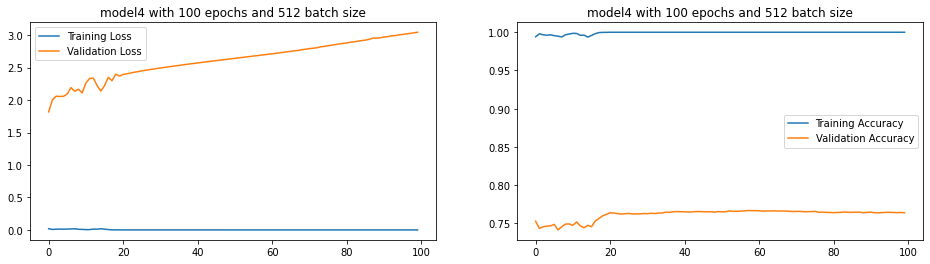

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1000
           1       0.88      0.86      0.87      1000
           2       0.69      0.66      0.67      1000
           3       0.60      0.59      0.59      1000
           4       0.71      0.72      0.72      1000
           5       0.68      0.68      0.68      1000
           6       0.80      0.82      0.81      1000
           7       0.80      0.78      0.79      1000
           8       0.84      0.85      0.85      1000
           9       0.83      0.83      0.83      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

Accuracy Score: 0.7624
Root Mean Square Error: 1.985698869416005


,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.153518e+00,0.585422,1.476373,0.4906,1.462329,0.4931,56.941556,20,100
1,DNN with 2 layers (no regularization),5.088747e-01,0.821222,2.399958,0.4782,2.324218,0.4891,98.645602,100,512
2,DNN with 3 layers (no regularization),9.747038e-01,0.645733,1.583275,0.4874,1.550352,0.4925,57.029117,20,100
3,DNN with 3 layers (no regularization),4.115602e-03,1.000000,5.543856,0.4792,5.315418,0.4848,99.278612,100,512
4,CNN with 2 convolution/max pooling layers (no ...,4.790628e-02,0.983622,2.097271,0.6964,2.077970,0.7016,262.758396,20,100
5,CNN with 2 convolution/max pooling layers (no ...,5.665425e-07,1.000000,3.596411,0.7314,3.639973,0.7327,867.420595,100,512
6,CNN with 3 convolution/max pooling layers (no ...,6.505650e-02,0.977822,1.798882,0.7262,1.777424,0.7344,329.427057,20,100
7,CNN with 3 convolution/max pooling layers (no ...,4.837489e-07,1.000000,3.045182,0.7640,3.026318,0.7624,1108.329722,100,512


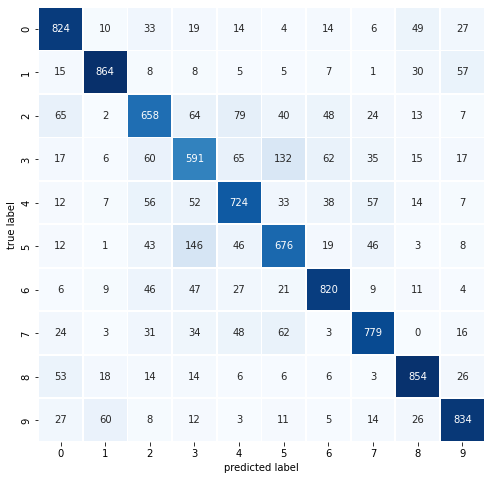

In [39]:
result4_2 = compile_train_plot_model(model4,100,512) 

new_col = ['CNN with 3 convolution/max pooling layers (no regularization)']   
result4_2.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result4_2, ignore_index = True)
assignment_result_table

## Experiment 5+ : You will conduct several more experiments. 

(a) Redo all the 4 experiments with some regularization technique. 


Epoch 1/100
88/88 [==============================] - 2s 13ms/step - loss: 2.7590 - accuracy: 0.2509 - val_loss: 2.3240 - val_accuracy: 0.3288
Epoch 2/100
88/88 [==============================] - 1s 10ms/step - loss: 2.2148 - accuracy: 0.3267 - val_loss: 2.0379 - val_accuracy: 0.3664
Epoch 3/100
88/88 [==============================] - 1s 10ms/step - loss: 2.0353 - accuracy: 0.3498 - val_loss: 1.8967 - val_accuracy: 0.3858
Epoch 4/100
88/88 [==============================] - 1s 10ms/step - loss: 1.9324 - accuracy: 0.3580 - val_loss: 1.8348 - val_accuracy: 0.3944
Epoch 5/100
88/88 [==============================] - 1s 10ms/step - loss: 1.8720 - accuracy: 0.3713 - val_loss: 1.7692 - val_accuracy: 0.4086
Epoch 6/100
88/88 [==============================] - 1s 10ms/step - loss: 1.8317 - accuracy: 0.3808 - val_loss: 1.7364 - val_accuracy: 0.4170
Epoch 7/100
88/88 [==============================] - 1s 10ms/step - loss: 1.8104 - accuracy: 0.3824 - val_loss: 1.7369 - val_accuracy: 0.4152
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

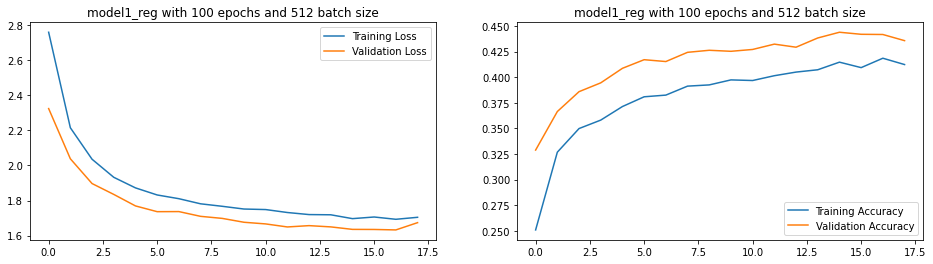

In [40]:
model1_reg = models.Sequential()
model1_reg.add(layers.InputLayer(input_shape=(32, 32, 3)))
model1_reg.add(layers.Flatten(name ='flatten'))
model1_reg.add(layers.Dense(name = "hidden_layer",units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model1_reg.add(layers.Dropout(0.3))
model1_reg.add(layers.Dense(name = "hidden_layer2",units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model1_reg.add(layers.Dropout(0.3))
model1_reg.add(layers.Dense(name = "output_layer",units=10, activation=tf.nn.softmax))

result1_reg = compile_train_model_with_reg(model1_reg, 100, 512)

In [41]:
new_col = ['DNN with 2 layers (with regularization)']   
result1_reg.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result1_reg, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.153518e+00,0.585422,1.476373,0.4906,1.462329,0.4931,56.941556,20,100
1,DNN with 2 layers (no regularization),5.088747e-01,0.821222,2.399958,0.4782,2.324218,0.4891,98.645602,100,512
2,DNN with 3 layers (no regularization),9.747038e-01,0.645733,1.583275,0.4874,1.550352,0.4925,57.029117,20,100
3,DNN with 3 layers (no regularization),4.115602e-03,1.000000,5.543856,0.4792,5.315418,0.4848,99.278612,100,512
4,CNN with 2 convolution/max pooling layers (no ...,4.790628e-02,0.983622,2.097271,0.6964,2.077970,0.7016,262.758396,20,100
5,CNN with 2 convolution/max pooling layers (no ...,5.665425e-07,1.000000,3.596411,0.7314,3.639973,0.7327,867.420595,100,512
6,CNN with 3 convolution/max pooling layers (no ...,6.505650e-02,0.977822,1.798882,0.7262,1.777424,0.7344,329.427057,20,100
7,CNN with 3 convolution/max pooling layers (no ...,4.837489e-07,1.000000,3.045182,0.7640,3.026318,0.7624,1108.329722,100,512
8,DNN with 2 layers (with regularization),1.704325e+00,0.412267,1.673801,0.4356,1.648613,0.4499,23.753780,100,512


Epoch 1/100
88/88 [==============================] - 2s 14ms/step - loss: 3.0603 - accuracy: 0.2233 - val_loss: 2.5209 - val_accuracy: 0.3192
Epoch 2/100
88/88 [==============================] - 1s 11ms/step - loss: 2.3707 - accuracy: 0.3110 - val_loss: 2.1465 - val_accuracy: 0.3604
Epoch 3/100
88/88 [==============================] - 1s 11ms/step - loss: 2.1243 - accuracy: 0.3378 - val_loss: 1.9755 - val_accuracy: 0.3704
Epoch 4/100
88/88 [==============================] - 1s 11ms/step - loss: 2.0197 - accuracy: 0.3430 - val_loss: 1.9261 - val_accuracy: 0.3710
Epoch 5/100
88/88 [==============================] - 1s 11ms/step - loss: 1.9436 - accuracy: 0.3523 - val_loss: 1.8361 - val_accuracy: 0.3918
Epoch 6/100
88/88 [==============================] - 1s 11ms/step - loss: 1.8871 - accuracy: 0.3612 - val_loss: 1.8262 - val_accuracy: 0.3896
Epoch 7/100
88/88 [==============================] - 1s 11ms/step - loss: 1.8555 - accuracy: 0.3690 - val_loss: 1.7877 - val_accuracy: 0.4016
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

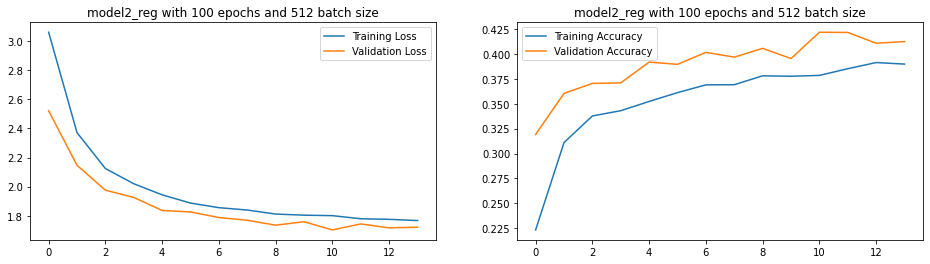

In [42]:
model2_reg = models.Sequential()
model2_reg.add(layers.InputLayer(input_shape=(32, 32, 3)))
model2_reg.add(layers.Flatten(name ='flatten'))
model2_reg.add(layers.Dense(name = "hidden_layer",units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model2_reg.add(layers.Dropout(0.3))
model2_reg.add(layers.Dense(name = "hidden_layer2",units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model2_reg.add(layers.Dropout(0.3))
model2_reg.add(layers.Dense(name = "hidden_layer3",units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model2_reg.add(layers.Dropout(0.3))
model2_reg.add(layers.Dense(name = "output_layer",units=10, activation=tf.nn.softmax))

result2_reg = compile_train_model_with_reg(model2_reg, 100, 512)

In [43]:
new_col = ['DNN with 3 layers (with regularization)']   
result2_reg.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result2_reg, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.153518e+00,0.585422,1.476373,0.4906,1.462329,0.4931,56.941556,20,100
1,DNN with 2 layers (no regularization),5.088747e-01,0.821222,2.399958,0.4782,2.324218,0.4891,98.645602,100,512
2,DNN with 3 layers (no regularization),9.747038e-01,0.645733,1.583275,0.4874,1.550352,0.4925,57.029117,20,100
3,DNN with 3 layers (no regularization),4.115602e-03,1.000000,5.543856,0.4792,5.315418,0.4848,99.278612,100,512
4,CNN with 2 convolution/max pooling layers (no ...,4.790628e-02,0.983622,2.097271,0.6964,2.077970,0.7016,262.758396,20,100
5,CNN with 2 convolution/max pooling layers (no ...,5.665425e-07,1.000000,3.596411,0.7314,3.639973,0.7327,867.420595,100,512
6,CNN with 3 convolution/max pooling layers (no ...,6.505650e-02,0.977822,1.798882,0.7262,1.777424,0.7344,329.427057,20,100
7,CNN with 3 convolution/max pooling layers (no ...,4.837489e-07,1.000000,3.045182,0.7640,3.026318,0.7624,1108.329722,100,512
8,DNN with 2 layers (with regularization),1.704325e+00,0.412267,1.673801,0.4356,1.648613,0.4499,23.753780,100,512
9,DNN with 3 layers (with regularization),1.767015e+00,0.389822,1.721547,0.4124,1.693927,0.4274,16.997587,100,512


Epoch 1/100
88/88 [==============================] - 11s 117ms/step - loss: 2.1412 - accuracy: 0.4776 - val_loss: 2.7166 - val_accuracy: 0.3314
Epoch 2/100
88/88 [==============================] - 10s 111ms/step - loss: 1.4547 - accuracy: 0.6417 - val_loss: 2.4647 - val_accuracy: 0.5462
Epoch 3/100
88/88 [==============================] - 10s 111ms/step - loss: 1.1801 - accuracy: 0.7009 - val_loss: 2.2261 - val_accuracy: 0.6372
Epoch 4/100
88/88 [==============================] - 10s 110ms/step - loss: 1.0273 - accuracy: 0.7419 - val_loss: 1.9558 - val_accuracy: 0.6958
Epoch 5/100
88/88 [==============================] - 10s 114ms/step - loss: 0.9263 - accuracy: 0.7790 - val_loss: 1.5136 - val_accuracy: 0.7260
Epoch 6/100
88/88 [==============================] - 10s 110ms/step - loss: 0.8728 - accuracy: 0.8012 - val_loss: 1.2147 - val_accuracy: 0.7408
Epoch 7/100
88/88 [==============================] - 10s 113ms/step - loss: 0.8209 - accuracy: 0.8256 - val_loss: 1.1341 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

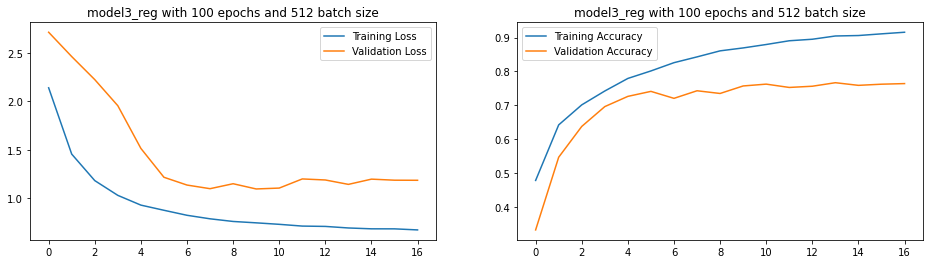

In [44]:
model3_reg = models.Sequential()
model3_reg.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model3_reg.add(layers.MaxPool2D((2, 2),strides=2))
model3_reg.add(layers.Dropout(0.3))
model3_reg.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model3_reg.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model3_reg.add(layers.Dropout(0.3))
model3_reg.add(layers.Flatten())
model3_reg.add(layers.BatchNormalization())
model3_reg.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model3_reg.add(layers.Dense(units=10, activation=tf.nn.softmax))

result3_reg = compile_train_model_with_reg(model3_reg, 100, 512)

In [45]:
new_col = ['CNN with 2 convolution/max pooling layers (with regularization)']   
result3_reg.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result3_reg, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.153518e+00,0.585422,1.476373,0.4906,1.462329,0.4931,56.941556,20,100
1,DNN with 2 layers (no regularization),5.088747e-01,0.821222,2.399958,0.4782,2.324218,0.4891,98.645602,100,512
2,DNN with 3 layers (no regularization),9.747038e-01,0.645733,1.583275,0.4874,1.550352,0.4925,57.029117,20,100
3,DNN with 3 layers (no regularization),4.115602e-03,1.000000,5.543856,0.4792,5.315418,0.4848,99.278612,100,512
4,CNN with 2 convolution/max pooling layers (no ...,4.790628e-02,0.983622,2.097271,0.6964,2.077970,0.7016,262.758396,20,100
5,CNN with 2 convolution/max pooling layers (no ...,5.665425e-07,1.000000,3.596411,0.7314,3.639973,0.7327,867.420595,100,512
6,CNN with 3 convolution/max pooling layers (no ...,6.505650e-02,0.977822,1.798882,0.7262,1.777424,0.7344,329.427057,20,100
7,CNN with 3 convolution/max pooling layers (no ...,4.837489e-07,1.000000,3.045182,0.7640,3.026318,0.7624,1108.329722,100,512
8,DNN with 2 layers (with regularization),1.704325e+00,0.412267,1.673801,0.4356,1.648613,0.4499,23.753780,100,512
9,DNN with 3 layers (with regularization),1.767015e+00,0.389822,1.721547,0.4124,1.693927,0.4274,16.997587,100,512


Epoch 1/100
88/88 [==============================] - 13s 138ms/step - loss: 2.1686 - accuracy: 0.4039 - val_loss: 2.5083 - val_accuracy: 0.4520
Epoch 2/100
88/88 [==============================] - 12s 131ms/step - loss: 1.5181 - accuracy: 0.5722 - val_loss: 2.1831 - val_accuracy: 0.6124
Epoch 3/100
88/88 [==============================] - 12s 132ms/step - loss: 1.2349 - accuracy: 0.6420 - val_loss: 1.8550 - val_accuracy: 0.6296
Epoch 4/100
88/88 [==============================] - 12s 131ms/step - loss: 1.0678 - accuracy: 0.6859 - val_loss: 1.4990 - val_accuracy: 0.6644
Epoch 5/100
88/88 [==============================] - 12s 132ms/step - loss: 0.9485 - accuracy: 0.7172 - val_loss: 1.1304 - val_accuracy: 0.7188
Epoch 6/100
88/88 [==============================] - 12s 132ms/step - loss: 0.8805 - accuracy: 0.7375 - val_loss: 0.9812 - val_accuracy: 0.7208
Epoch 7/100
88/88 [==============================] - 12s 132ms/step - loss: 0.8109 - accuracy: 0.7560 - val_loss: 0.8284 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

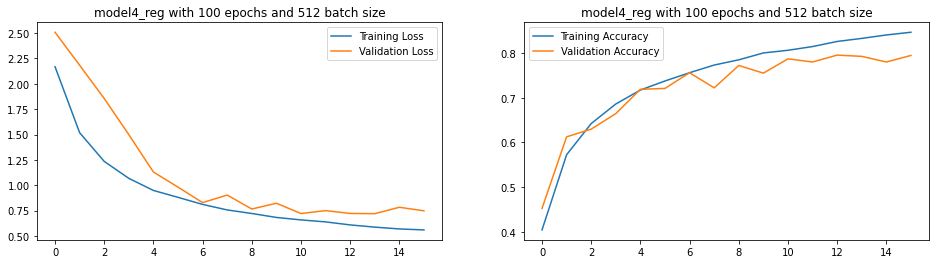

In [46]:
model4_reg = models.Sequential()
model4_reg.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model4_reg.add(layers.MaxPool2D((2, 2),strides=2))
model4_reg.add(layers.Dropout(0.3))
model4_reg.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4_reg.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model4_reg.add(layers.Dropout(0.3))
model4_reg.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4_reg.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model4_reg.add(layers.Dropout(0.3))
model4_reg.add(layers.Flatten())
model4_reg.add(layers.BatchNormalization())
model4_reg.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model4_reg.add(layers.Dense(units=10, activation=tf.nn.softmax))

result4_reg = compile_train_model_with_reg(model4_reg, 100, 512)


In [47]:
new_col = ['CNN with 3 convolution/max pooling layers (with regularization)']   
result4_reg.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result4_reg, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.153518e+00,0.585422,1.476373,0.4906,1.462329,0.4931,56.941556,20,100
1,DNN with 2 layers (no regularization),5.088747e-01,0.821222,2.399958,0.4782,2.324218,0.4891,98.645602,100,512
2,DNN with 3 layers (no regularization),9.747038e-01,0.645733,1.583275,0.4874,1.550352,0.4925,57.029117,20,100
3,DNN with 3 layers (no regularization),4.115602e-03,1.000000,5.543856,0.4792,5.315418,0.4848,99.278612,100,512
4,CNN with 2 convolution/max pooling layers (no ...,4.790628e-02,0.983622,2.097271,0.6964,2.077970,0.7016,262.758396,20,100
5,CNN with 2 convolution/max pooling layers (no ...,5.665425e-07,1.000000,3.596411,0.7314,3.639973,0.7327,867.420595,100,512
6,CNN with 3 convolution/max pooling layers (no ...,6.505650e-02,0.977822,1.798882,0.7262,1.777424,0.7344,329.427057,20,100
7,CNN with 3 convolution/max pooling layers (no ...,4.837489e-07,1.000000,3.045182,0.7640,3.026318,0.7624,1108.329722,100,512
8,DNN with 2 layers (with regularization),1.704325e+00,0.412267,1.673801,0.4356,1.648613,0.4499,23.753780,100,512
9,DNN with 3 layers (with regularization),1.767015e+00,0.389822,1.721547,0.4124,1.693927,0.4274,16.997587,100,512


In [48]:
assignment_result_table.to_csv('assignment2_result1.csv')

## Load HDF5 Model Format 

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/models/model_0.7224.h5')

In [ ]:
preds = model.predict(x_test_norm)

In [ ]:
preds.shape

(10000, 10)

### Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.00%,0.00%,0.00%,99.10%,0.00%,0.89%,0.01%,0.00%,0.00%,0.00%
1,0.02%,44.51%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,55.47%,0.00%
2,2.58%,0.92%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,96.50%,0.00%
3,99.76%,0.00%,0.07%,0.03%,0.00%,0.00%,0.00%,0.00%,0.14%,0.00%
4,0.00%,0.00%,0.23%,2.21%,96.68%,0.00%,0.87%,0.00%,0.00%,0.00%
5,0.00%,0.00%,0.00%,0.00%,0.00%,0.02%,99.98%,0.00%,0.00%,0.00%
6,0.00%,99.99%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.01%
7,0.00%,0.00%,1.91%,0.11%,0.11%,0.01%,97.86%,0.00%,0.00%,0.00%
8,0.02%,0.00%,0.00%,94.18%,0.34%,5.16%,0.29%,0.01%,0.00%,0.00%
9,0.00%,99.38%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.62%


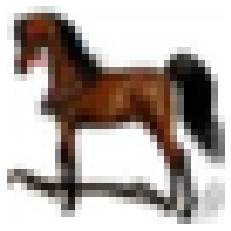

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

8

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 batch_normalization (BatchN  (None, 9216)             3

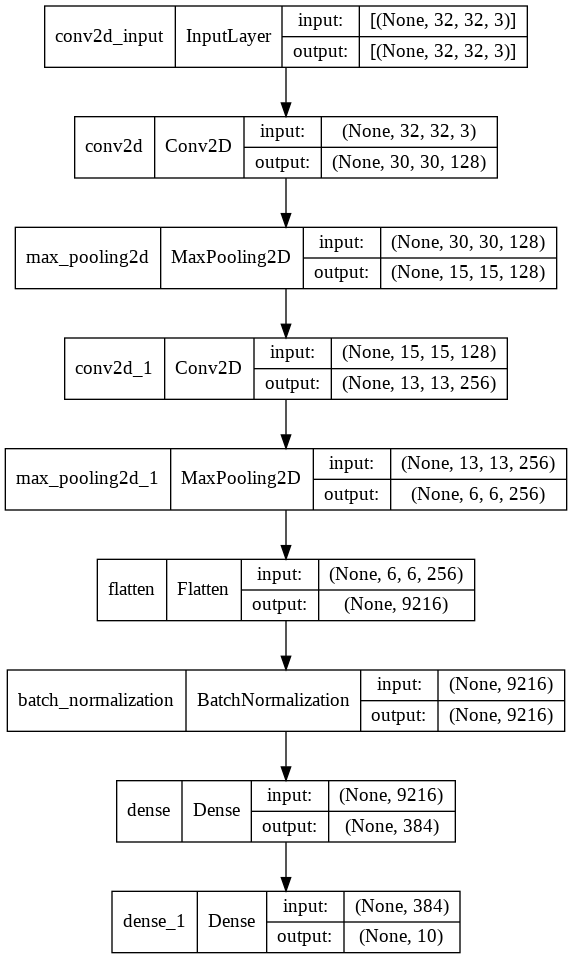

In [ ]:
model.summary()

keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

In [ ]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten',
 'batch_normalization',
 'dense',
 'dense_1']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


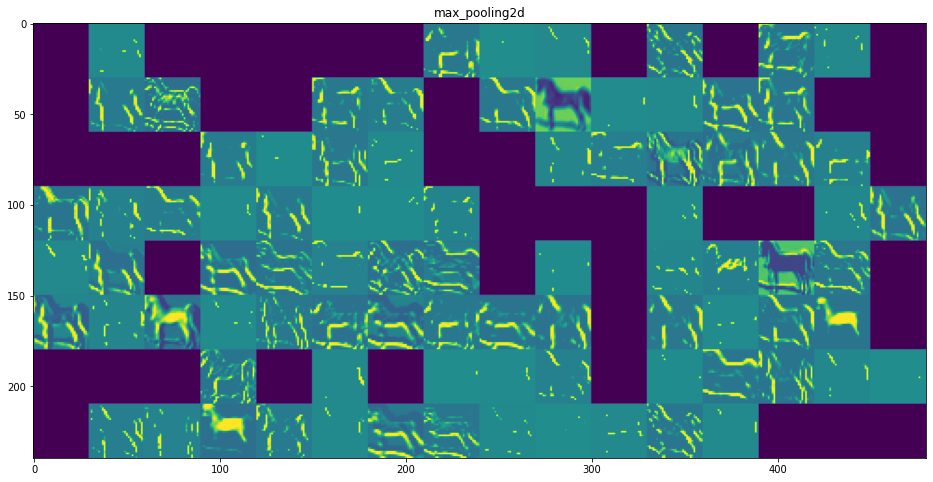

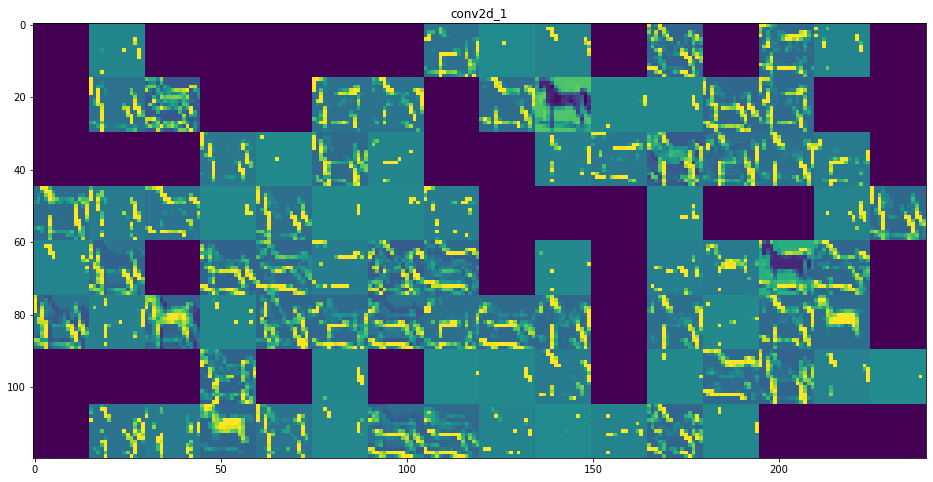

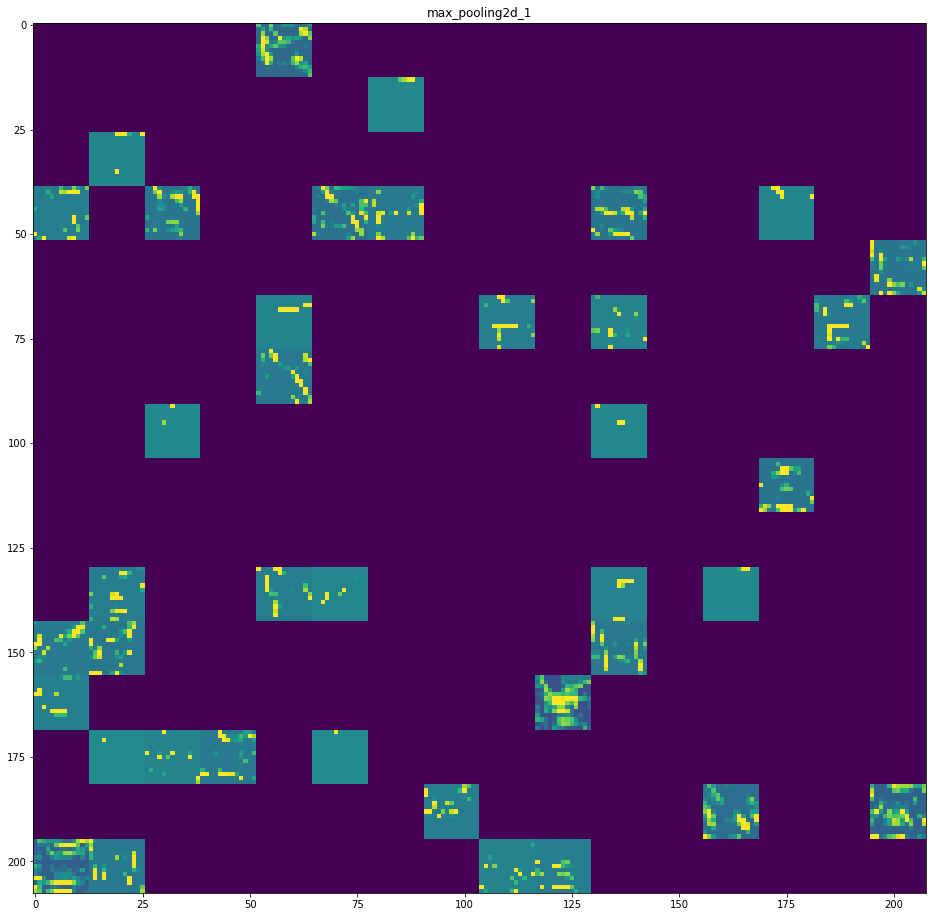

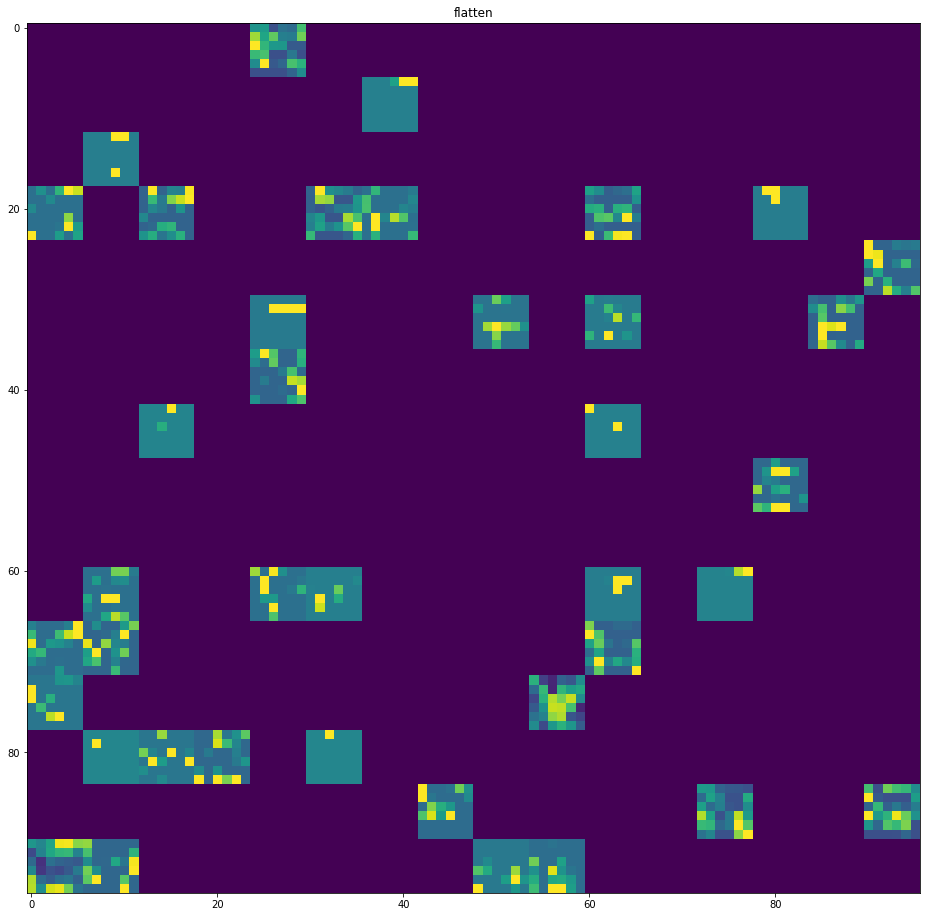

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[1:5]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map #128
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features) #15
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix 
    n_cols = n_features // images_per_row #8
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();